### Importing libraries

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import folium
from folium import plugins
import plotly.express as px
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture

In [5]:
#Read the data
df = pd.read_csv('listings.csv')

### Exploratory Data Analysis

In [6]:
#Display first 5 rows
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,46,2019-07-14,0.39,2,288
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,274,2019-07-26,4.64,1,212
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,75,2019-07-21,0.60,1,127


In [71]:
df.shape

(48864, 11)

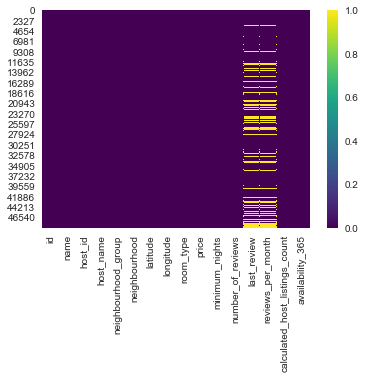

In [8]:
#Heatmap of null values
sns.heatmap(df.isnull(), cmap = 'viridis')

### Feature selection


In [9]:
#columns to drop 
columns2drop = ['last_review', 'reviews_per_month', 'host_name','name', 'neighbourhood', 'reviews_per_month']

In [10]:
df = df.drop(columns2drop, axis = 1)

In [11]:
#df = pd.get_dummies(df, prefix=['neighbourhood_group','room_type'])

In [12]:
# Seperating numerical data for normalization later
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_df = df.select_dtypes(include=numerics)

In [13]:
num_df.dtypes

id                                  int64
host_id                             int64
latitude                          float64
longitude                         float64
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

### Normalizaing

In [14]:
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(num_df)
scaled_df = pd.DataFrame(scaled_values, columns= num_df.columns)

In [15]:
scaled_df.head()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
0,0.000000,0.000001,0.615181,0.490469,0.0225,0.000000,0.071987,0.002924,0.789041
1,0.000028,0.000008,0.749449,0.569257,0.0150,0.001601,0.000000,0.000000,1.000000
2,0.000033,0.000009,0.449214,0.535649,0.0089,0.000000,0.428795,0.000000,0.580822
3,0.000065,0.000017,0.723977,0.565324,0.0080,0.007206,0.014085,0.000000,0.000000
4,0.000067,0.000017,0.600761,0.506972,0.0200,0.001601,0.117371,0.000000,0.347945


### One hot encoding important categorical data

In [16]:
columns_encoding = ['neighbourhood_group','room_type']
neighbor_encoding = pd.get_dummies(df['neighbourhood_group'])
room_encoding = pd.get_dummies(df.room_type)

In [17]:
X = pd.concat([scaled_df,neighbor_encoding, room_encoding], axis=1)

In [18]:
X.isnull().sum()

id                                0
host_id                           0
latitude                          0
longitude                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
calculated_host_listings_count    0
availability_365                  0
Bronx                             0
Brooklyn                          0
Manhattan                         0
Queens                            0
Staten Island                     0
Entire home/apt                   0
Private room                      0
Shared room                       0
dtype: int64

### Cleaned, normalized and one-hot-encoded dataset

In [19]:
X.head()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Entire home/apt,Private room,Shared room
0,0.000000,0.000001,0.615181,0.490469,0.0225,0.000000,0.071987,0.002924,0.789041,0,0,1,0,0,1,0,0
1,0.000028,0.000008,0.749449,0.569257,0.0150,0.001601,0.000000,0.000000,1.000000,0,0,1,0,0,0,1,0
2,0.000033,0.000009,0.449214,0.535649,0.0089,0.000000,0.428795,0.000000,0.580822,0,1,0,0,0,1,0,0
3,0.000065,0.000017,0.723977,0.565324,0.0080,0.007206,0.014085,0.000000,0.000000,0,0,1,0,0,1,0,0
4,0.000067,0.000017,0.600761,0.506972,0.0200,0.001601,0.117371,0.000000,0.347945,0,0,1,0,0,1,0,0


### Elbow method to choose optimum number of clusters in K-means

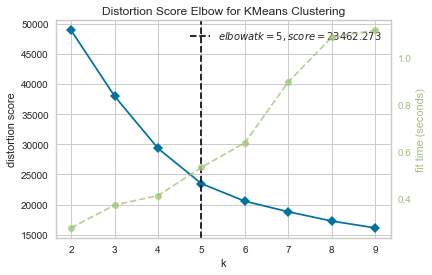

In [20]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,10))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

### Machine Learning Model

### Kmeans

In [21]:
model2 = KMeans(n_clusters=5)
model2.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

### Hierarchical Clustering

In [23]:
model_hierical = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
model_hierical.fit(X)
hierical_labels = model_hierical.labels_

### Gaussian Mixture Model Clusering

In [47]:
model_gmm = GaussianMixture(n_components=5)
model_gmm.fit(X)
gmm_labels = model_gmm.predict(X)

### Data Visualization with folium

In [442]:
def generateBaseMap(default_location=[40.693943,-73.985880]) :
    base_map = folium.Map(location=default_location, tiles= 'CartoDB dark_matter' ) 
    return base_map


In [443]:
base_map = generateBaseMap()


plugins.HeatMap(data=df[['latitude',
                         'longitude',
                         'price']].groupby(['latitude',
                                            'longitude']).mean().reset_index().values.tolist(),
        radius=8, max_zoom=13).add_to(base_map) 
base_map.save('index.html')

In [1]:
#base_map

In [445]:
data=df[['latitude','longitude',
                 'price']].groupby(['latitude', 
                                    'longitude']).mean().reset_index()

In [446]:
sns.set_context('talk')

In [447]:
#sns.scatterplot(df.latitude, df.longitude, hue = df.neighbourhood_group)

In [65]:
labels_df = pd.DataFrame({'Kmeans_label': model2.labels_ ,
                          'Hierical_label': model_hierical.labels_,
                          'GMM_label': gmm_labels})
df_with_labels = pd.concat([df,labels_df], axis=1)

In [49]:
df_with_labels.head()

,id,host_id,neighbourhood_group,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,Kmeans_label,Hierical_label,GMM_labels
0,2595,2845,Manhattan,40.75362,-73.98377,Entire home/apt,225,1,46,2,288,3,1,1
1,3647,4632,Manhattan,40.80902,-73.94190,Private room,150,3,0,1,365,4,4,4
2,3831,4869,Brooklyn,40.68514,-73.95976,Entire home/apt,89,1,274,1,212,1,2,3
3,5022,7192,Manhattan,40.79851,-73.94399,Entire home/apt,80,10,9,1,0,3,1,1
4,5099,7322,Manhattan,40.74767,-73.97500,Entire home/apt,200,3,75,1,127,3,1,1


In [58]:
vc_Kmeans = df_with_labels.Kmeans_label.value_counts()
vc_Hierical = df_with_labels.Hierical_label.value_counts()
vc_GMM = df_with_labels.GMM_labels.value_counts()

In [60]:
vc_clusers = pd.concat([vc_Kmeans,vc_Hierical,vc_GMM], axis = 1)

In [61]:
vc_clusers

,Kmeans_label,Hierical_label,GMM_labels
0,5888,8183,10549
1,9652,13054,13054
2,10549,9565,4617
3,13526,10131,12242
4,9249,7931,8402


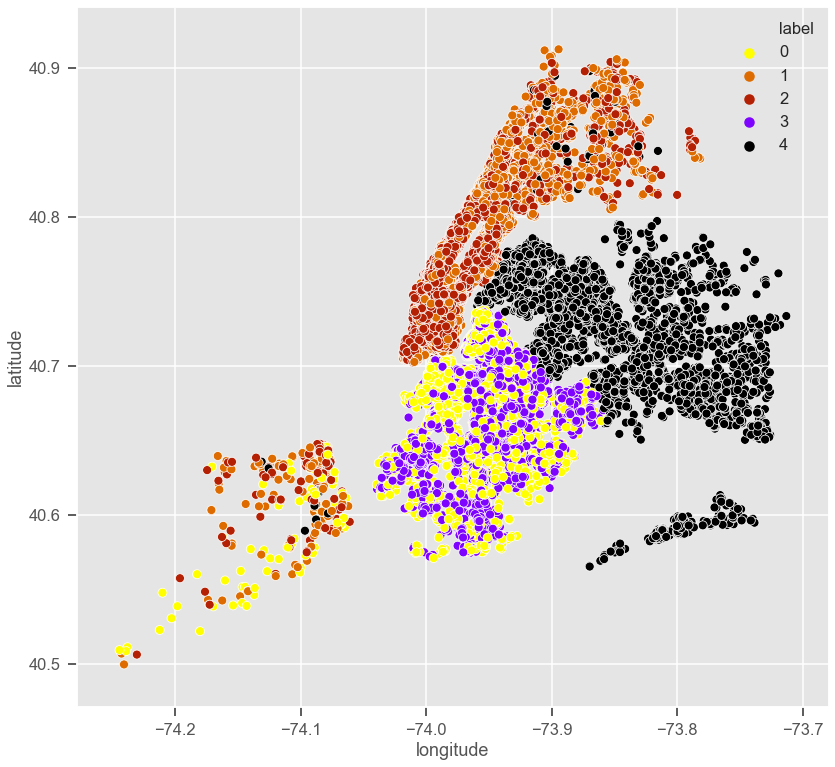

In [451]:
p#lt.figure(figsize=(12,12))
sns.scatterplot('longitude','latitude', hue = 'label', data = df_with_labels,palette='gnuplot_r', legend='full' )

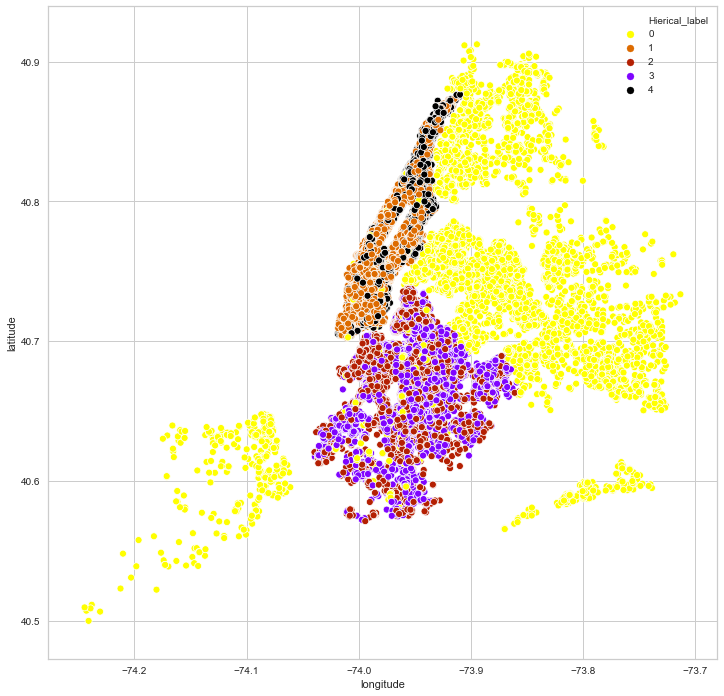

In [36]:
plt.figure(figsize=(12,12))
sns.scatterplot('longitude','latitude', hue = 'Hierical_label', data = df_with_labels,palette='gnuplot_r', legend='full' )

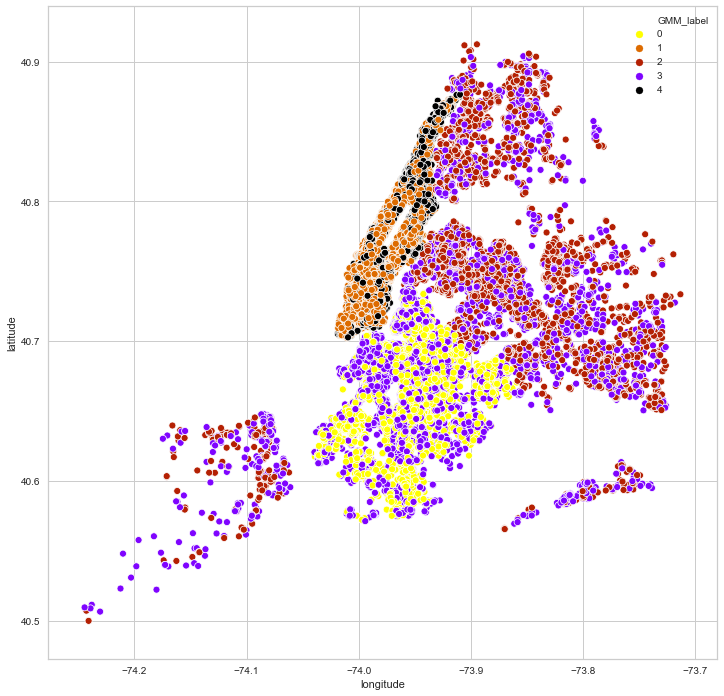

In [66]:
plt.figure(figsize=(12,12))
sns.scatterplot('longitude','latitude', hue = 'GMM_label', data = df_with_labels,palette='gnuplot_r', legend='full' )

In [70]:
price_Kmeans = df_with_labels.groupby('Kmeans_label').mean()['price']
price_Hierical = df_with_labels.groupby('Hierical_label').mean()['price']
price_GMM = df_with_labels.groupby('GMM_label').mean()['price']
price_clusters = pd.concat([price_Kmeans, price_Hierical,price_GMM], axis = 1)
price_clusters.columns = ['Kmeans price','Hierical price', 'GMM price']
price_clusters

,Kmeans price,Hierical price,GMM price
0,99.114810,95.521814,75.441464
1,177.385309,245.705454,245.705454
2,75.441464,177.641610,70.566818
3,242.010498,76.537953,170.864810
4,111.972213,118.139705,116.615449


In [453]:
for index, row in df_with_labels.iterrows():
    radius = 0.05
    if row['label'] == 0:
        color="#E37222" # tangerine
    elif row['label'] == 1:
        color="#0A8A9F" # teal
    elif row['label'] == 2:
        color="red"
    #elif row['label'] == 3:
    #    color = 'black'
    #else:
    #    color = 'green'
    
    folium.CircleMarker(location=(row["latitude"],
                                  row["longitude"]),
                        radius=radius,
                        color=color,
                        fill=True).add_to(base_map)

In [2]:
#base_map